PS:
For the supervised models, I applied globaly the same data processing except for the part 'Extract all the noun in the Title'. Unlike for unsupervised method here I will extract all the proper noun and the noun, in singular and in plural.

In this notebook a simple processing will be applied to the Tags in order to train the models.

# Load libraries and set figures parameters

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [2]:
# Figures parameters
sns.set()
plt.style.use('seaborn-whitegrid')
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style('whitegrid')

# Import dataset and sub-sampling

In [3]:
# Import Datasets

data_stackoverflow = pd.read_csv('QueryResults.csv', low_memory=False)

# Keep the questions with Views >30.
# Then I took a sample of 5000 row in order to encode fatser the Text Data
# Only keep the columns 'Title', 'Tags' and 'ViewCount'.
data_stackoverflow = data_stackoverflow[data_stackoverflow['ViewCount']>=30]
df_sample = data_stackoverflow.iloc[:,[-6, -5]].reset_index().drop(['index'], axis=1)
df_sample

,Title,Tags
0,Grouping XML nodes based on the first element ...,<xml><xslt><grouping>
1,Connection error with SQL Server 2012 with Python,<python><sql-server><python-3.x><linux>
2,I can't view WhatsApp media images in WhatsApp...,<android><image><filesystems><whatsapp>
3,How to use laravel-vue-pagination in Vue 3?,<javascript><vue.js><vuejs3>
4,"Is this code clean (using policies, resources,...",<laravel>
...,...,...
36831,Export pandas dataframe to excel sheet,<pandas>
36832,Using Athena federated query to read dynamoDB ...,<amazon-web-services><amazon-athena>
36833,flask application starts correctly but shows a...,<flask>
36834,How to use poetry file to build docker image?,<docker><arm><python-poetry>


# Remove punctuation and extract all the noun in the Title

Here, I perform a simple preprocessing on the content of Title column to make them more amenable for analysis, and reliable results. To do that, we’ll use a regular expression to remove any punctuation, and then lowercase the text.

In [4]:
# Load the regular expression library
import re

# Remove punctuation
df_sample['Title'] = df_sample['Title'].map(lambda x: re.sub('[,\.!?]<>-', ' ', x))
df_sample['Tags'] = df_sample['Tags'].map(lambda x: re.sub('[,\.!?<>-]', ' ', x))


# In the following I will delete everything except nouns and names. Indeed, the names (like Python, Windows, Google etc.) are the most relevant to propose tags.
import nltk

def extract_NN(sent):
    grammar = r"""
    
    NP:
        {<NNP>} # proper noun, singular ex. 'Dupont'
        {<NNPS>} # proper noun, plural ex. 'Americans'
        {<NN>} # noun, singular 'desk'
        {<NNS>} # noun plural 'desks'
        {<FW>} # foreign word
                            
    """
    chunker = nltk.RegexpParser(grammar)
    ne = []
    chunk = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))
    for tree in chunk.subtrees(filter=lambda t: t.label() == 'NP'):
        ne.append(' '.join([child[0] for child in tree.leaves()]))
    return ne


df_sample['Title_extracted'] = df_sample.Title.apply(extract_NN)
df_sample

,Title,Tags,Title_extracted
0,Grouping XML nodes based on the first element ...,xml xslt grouping,"[XML, nodes, element, value, node, XSLT]"
1,Connection error with SQL Server 2012 with Python,python sql server python 3 x linux,"[Connection, error, SQL, Server, Python]"
2,I can't view WhatsApp media images in WhatsApp...,android image filesystems whatsapp,"[WhatsApp, media, images, WhatsApp, Private, f..."
3,How to use laravel-vue-pagination in Vue 3?,javascript vue js vuejs3,"[laravel-vue-pagination, Vue]"
4,"Is this code clean (using policies, resources,...",laravel,"[code, clean, policies, resources, validation]"
...,...,...,...
36831,Export pandas dataframe to excel sheet,pandas,"[Export, pandas, dataframe, sheet]"
36832,Using Athena federated query to read dynamoDB ...,amazon web services amazon athena,"[Athena, query, dynamoDB, table]"
36833,flask application starts correctly but shows a...,flask,"[application, error]"
36834,How to use poetry file to build docker image?,docker arm python poetry,"[poetry, file, docker, image]"


# Tokenize and Lemmatize words

- Let’s tokenize each sentence into a list of words and remove unnecessary characters altogether.

In [5]:
import gensim
from gensim.utils import simple_preprocess
from nltk.stem.wordnet import WordNetLemmatizer


def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df_sample.Title_extracted))

data_tags = list(sent_to_words(df_sample.Tags))



# Lemmatize
def Text_preprocessor(texts):
    lemmatizer = WordNetLemmatizer() # Lemmatize all words
    texts = [[lemmatizer.lemmatize(token) for token in doc] for doc in texts]
    return texts

data_words = Text_preprocessor(data_words)
data_tags = Text_preprocessor(data_tags)

for i in range(0,5):
    print(f'Text{i+1}: {data_words[i]}')
    print(f'Tags{i+1}: {data_tags[i]}\n')

Text1: ['xml', 'node', 'element', 'value', 'node', 'xslt']
Tags1: ['xml', 'xslt', 'grouping']

Text2: ['connection', 'error', 'sql', 'server', 'python']
Tags2: ['python', 'sql', 'server', 'python', 'linux']

Text3: ['whatsapp', 'medium', 'image', 'whatsapp', 'private', 'folder', 'gallery']
Tags3: ['android', 'image', 'filesystems', 'whatsapp']

Text4: ['laravel', 'vue', 'pagination', 'vue']
Tags4: ['javascript', 'vue', 'j', 'vuejs']

Text5: ['code', 'clean', 'policy', 'resource', 'validation']
Tags5: ['laravel']



# Remove Stopwords

In [6]:
# Let’s define the functions to remove the stopwords.
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'way', 'subject', 're', 'edu', 'be', 'have', 'do', 'say', 
                   'get', 'make', 'go', 'know', 'take', 'see', 'come', 'think', 
                   'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 'work',
                   'seem', 'feel', 'try', 'leave', 'call'])

# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)
data_tags_nostops = remove_stopwords(data_tags)


# Data shaping for the analysis
Texts = []
for i in data_words_nostops:
    Texts.append(' '.join(map(str, i)))

Tags = []
for i in data_tags_nostops:
    Tags.append(' '.join(map(str, i)))


# Create the data on which I will do the analysis
mydata = pd.DataFrame()

mydata['Text'], mydata['Tags'] = Texts, Tags
mydata

,Text,Tags
0,xml node element value node xslt,xml xslt grouping
1,connection error sql server python,python sql server python linux
2,whatsapp medium image whatsapp private folder ...,android image filesystems whatsapp
3,laravel vue pagination vue,javascript vue vuejs
4,code clean policy resource validation,laravel
...,...,...
36831,export panda dataframe sheet,panda
36832,athena query dynamodb table,amazon web service amazon athena
36833,application error,flask
36834,poetry file docker image,docker arm python poetry


# Extract the most frequent tags

In [7]:
# Convert the text in tags into a list of words
mydata['Tags_list'] = mydata.Tags.apply(lambda x: x[:].split(' '))


# Select the 200 most frequent words in tags
Most_freq = pd.Series(' '.join(mydata['Tags']).split()).value_counts()[:200].index


# Add the 200 most frequent tags to all the row of mydata
Most_freq_tags=[]
for i in range(0, len(Most_freq)):
    Most_freq_tags.append(Most_freq[i])

mydata['Most_freq_tags'] = pd.Series([Most_freq_tags for x in range(len(mydata.index))]) # Add the list to all the row


# For each question search the common tags between the Stack Overflow Tags and the list of the most frequent tags of the dataframe
# By doing this I keep only the tags that figure in the lise of the most frequent ones.
common_tags = []
for i in range(0,len(mydata)):
    List_tags = mydata['Tags_list'][i]
    Frequent_tags = mydata['Most_freq_tags'][i]
    common_tags.append([x for x in Frequent_tags if x in List_tags])

mydata['Common_tags'] = common_tags # Add the Common_tags to mydata


# Convert the list of Common tags into Text
Tags_final = []

for i in mydata['Common_tags']:
    Tags_final.append(' '.join(map(str, i)))
mydata['Tags_final'] = Tags_final


# Columns selection for modeling
mydata = mydata.loc[:, ['Text', 'Common_tags', 'Tags_final']]
mydata.head()

,Text,Common_tags,Tags_final
0,xml node element value node xslt,[xml],xml
1,connection error sql server python,"[python, sql, server, linux]",python sql server linux
2,whatsapp medium image whatsapp private folder ...,"[android, image]",android image
3,laravel vue pagination vue,"[javascript, vue, vuejs]",javascript vue vuejs
4,code clean policy resource validation,[laravel],laravel


# WordCloud of the words in the title and the tags after processing

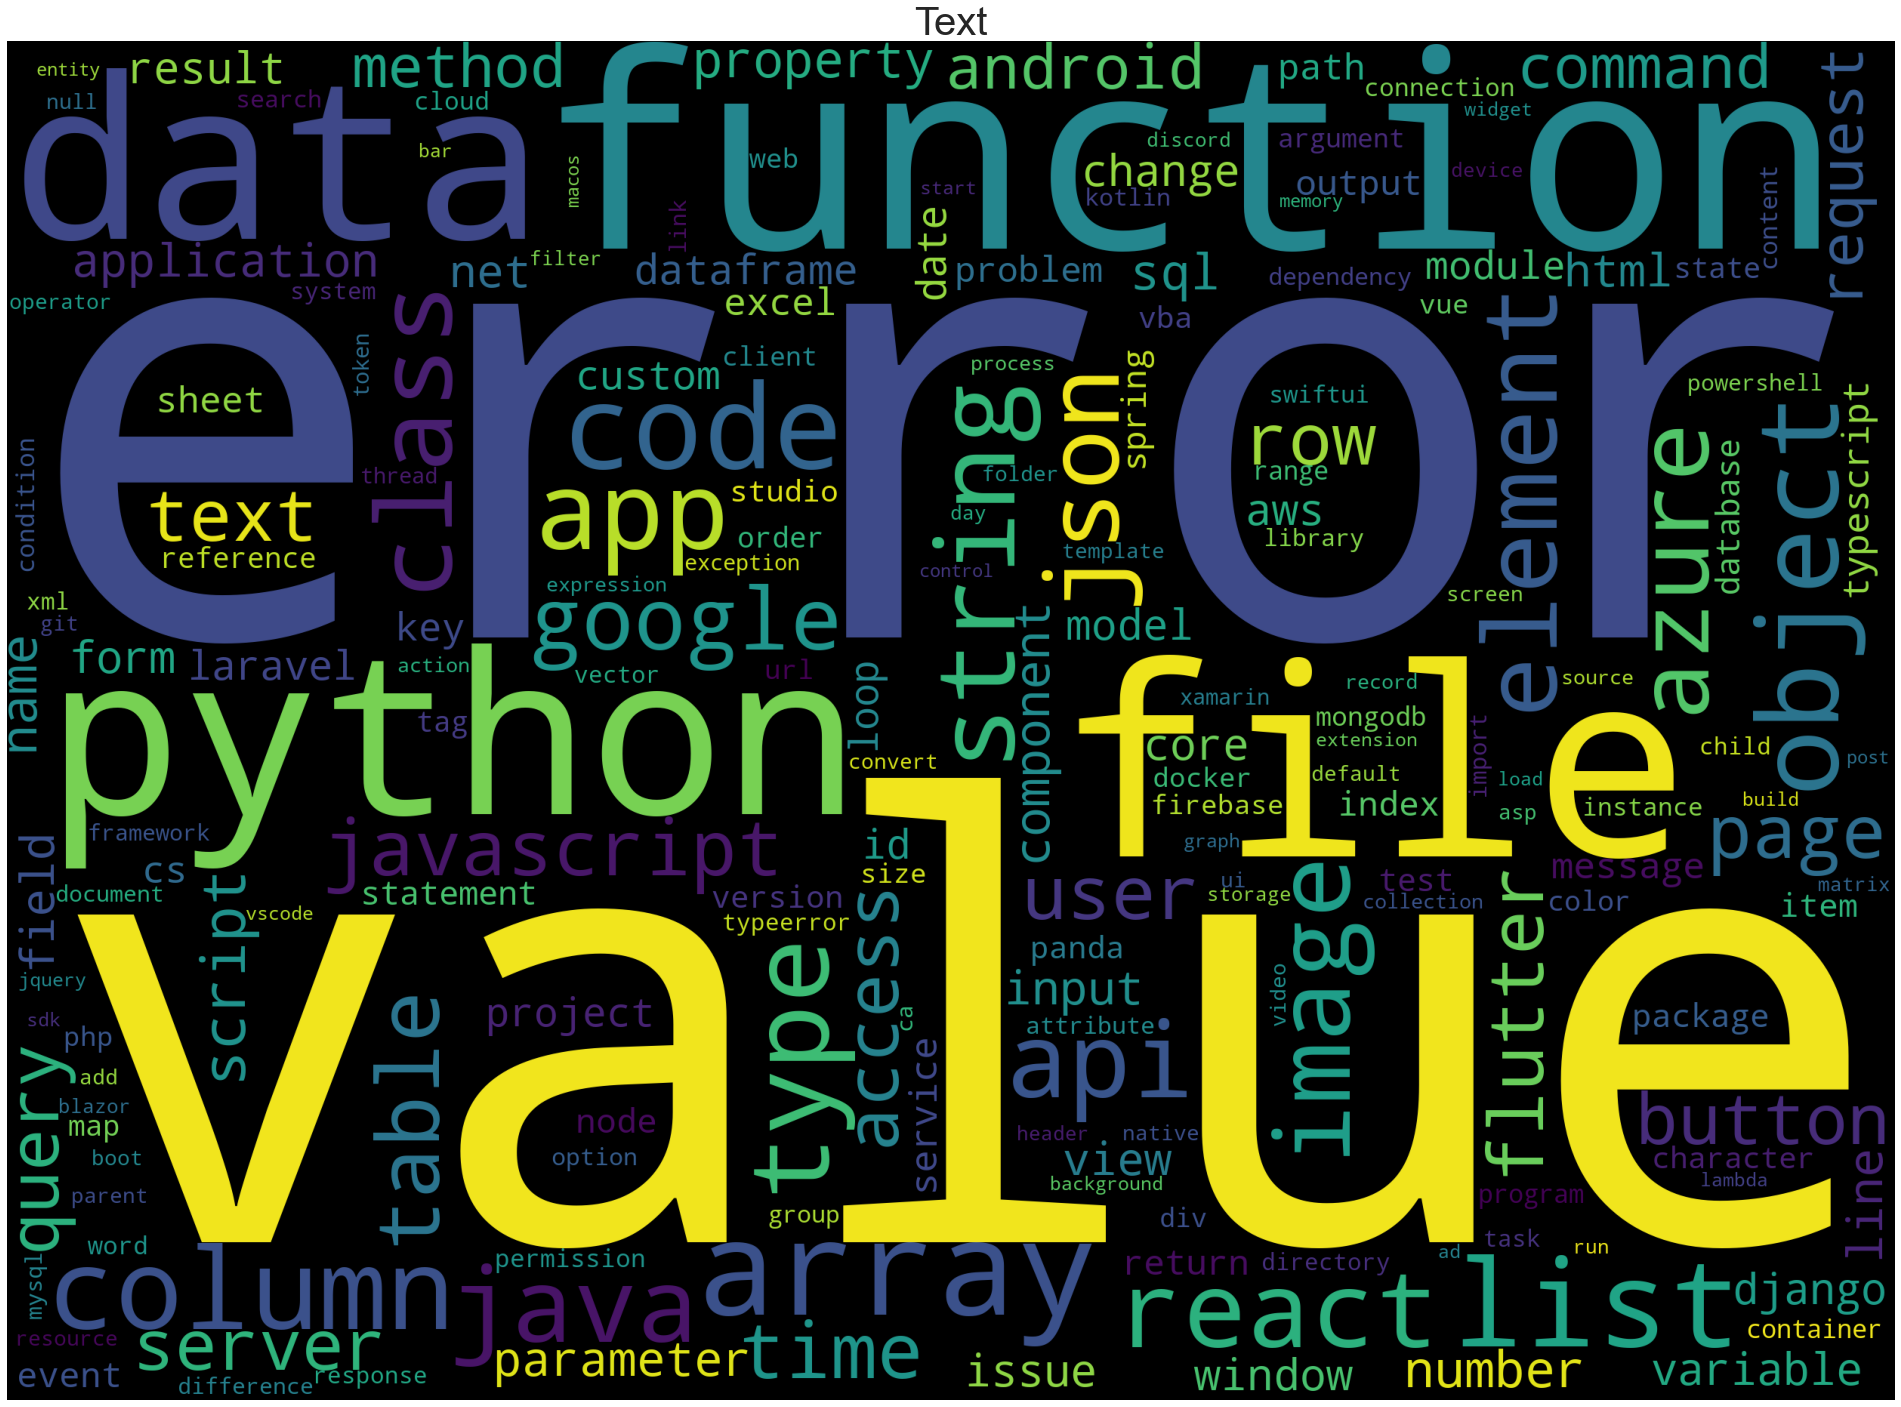

In [8]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

text = mydata.Text.values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Text",fontsize=40)
plt.imshow(cloud_toxic)

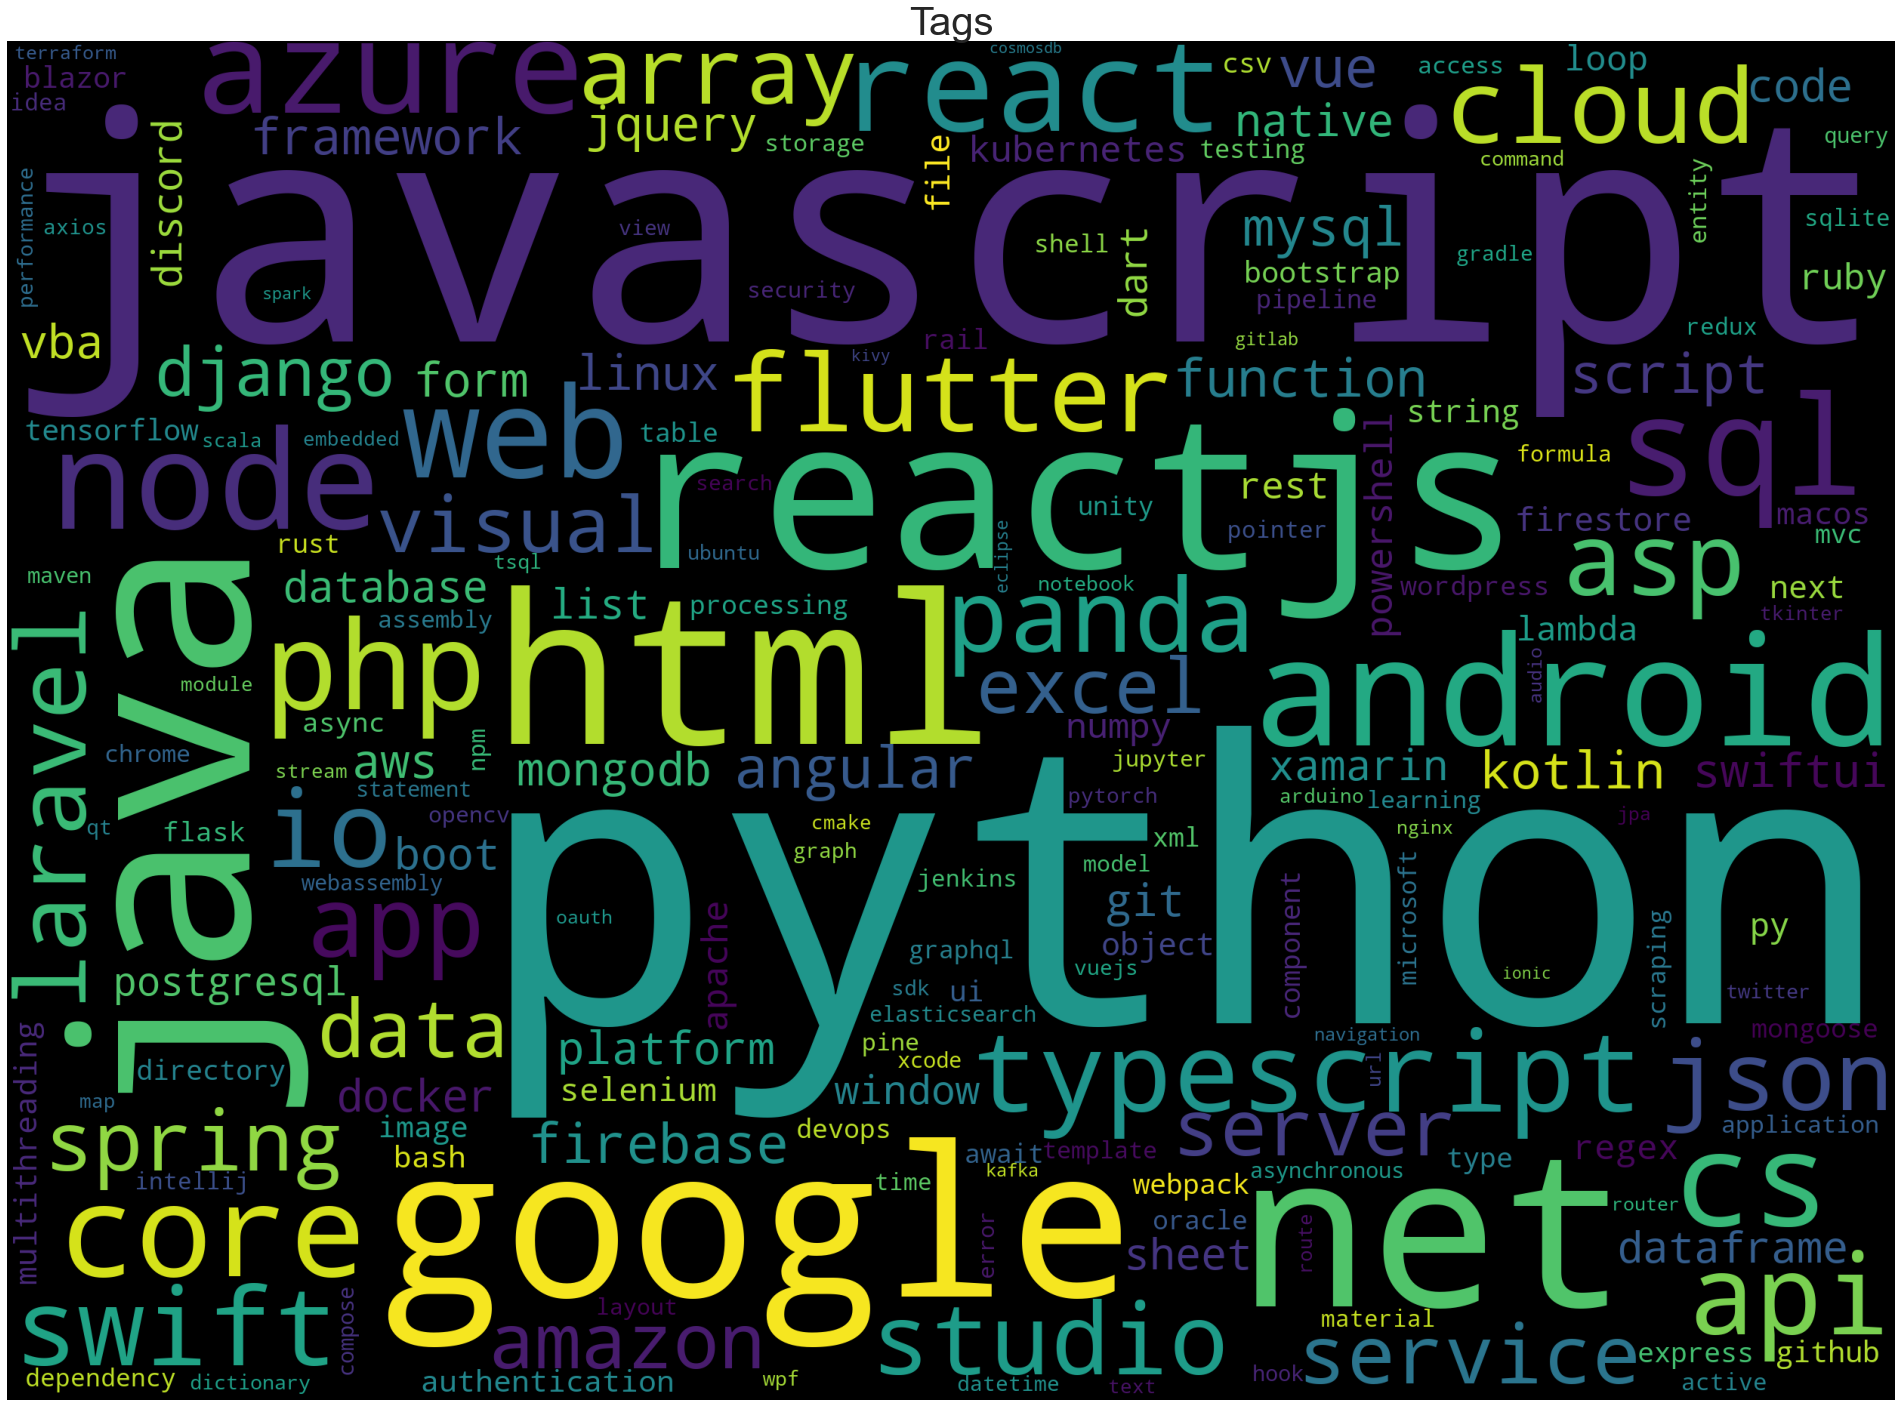

In [9]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize=(40,25))

text = mydata.Tags_final.values
cloud_toxic = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='black',
                          collocations=False,
                          width=2500,
                          height=1800
                         ).generate(" ".join(text))
plt.axis('off')
plt.title("Tags",fontsize=40)
plt.imshow(cloud_toxic)

# Modeling

- Define X

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer


# Define X
tfidf_vectorizer = TfidfVectorizer(min_df=3, # ignores terms whose document frequency is less than 3
                                    max_df=0.85, # ignores terms whose document frequency is greater than 85%
                                    #max_features=1000,
                                    ngram_range=(1,1) # it allows us to choose a range of word lengths, I’m sticking with 1 word
                                    )
X_tfidf = tfidf_vectorizer.fit_transform(mydata['Text'].tolist())
#tfidf_feature_names = tfidf_vectorizer.get_feature_names()

- Define Y

In [9]:
from sklearn.preprocessing import MultiLabelBinarizer

Tags = mydata['Common_tags']

# Converting the multi-label classification to a binary output
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(mydata['Common_tags'])

- Split the data into train set and test set

In this data set we have a problem that is Multi-labeled tags. Thus, to avoid any error related to Multi labeled text I chose to use the IterativeStratification function from skmultilearn.model_selection.iterative_stratification. See the discussion in the link below for more information: https://stackoverflow.com/questions/64838108/multi-labeled-image-classification-with-imbalanced-data-how-to-split-it


In [10]:
from skmultilearn.model_selection.iterative_stratification import IterativeStratification

stratifier = IterativeStratification(n_splits=2, order=2, 
                                     sample_distribution_per_fold=[1.0 - 0.7, 0.7]) # this class is a generator that produces
                                                                                    # k-folds. we just want to iterate it 
                                                                                    # once to make a single static split
                                                                                    # NOTE: needs to be computed on hard labels.

train_indexes, test_indexes = next(stratifier.split(X=X_tfidf, y=Y))

# text array shape (N_samp,)
x_train_tfidf, x_test_tfidf = X_tfidf[train_indexes], X_tfidf[test_indexes]

# labels array shape (N_samp, n_classes)
y_train_tfidf, y_test_tfidf = Y[train_indexes, :], Y[test_indexes, :]


print('x_train', x_train_tfidf.shape,'\n', 'y_train', y_train_tfidf.shape, '\n')
print('x_test', x_test_tfidf.shape, '\n' , 'y_test', y_test_tfidf.shape)

x_train (25785, 4366) 
 y_train (25785, 200) 

x_test (11051, 4366) 
 y_test (11051, 200)


In [15]:
# Calculate f1 score for 4 multinomial models

# Load library
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score, accuracy_score



# Define a F1_score function
# Micro:
def f1_micro(test, pred):
    f1 = f1_score(test, pred, average = 'micro') # Calculate metrics globally by counting the total true positives, false negatives and false positives.
    return f1

# Macro:
def f1_macro(test, pred):
    f1 = f1_score(test, pred, average = 'macro') # Calculate metrics for each label, and find their unweighted mean. This does not take label imbalance into account.
    return f1

# Accuracy:
def acc_score(test, pred):
    acc_ = accuracy_score(test, pred)
    return acc_


# Print the score
def print_score(test, pred):
    print("Clf: ", classifier.__class__.__name__)
    print("F1 micro: {}".format(f1_micro(test, pred)))
    print("F1 macro: {}".format(f1_macro(test, pred)))
    print("Accuracy: {}".format(acc_score(test, pred)))
    print("---")


# The models
lr = LogisticRegression()
#nb_clf = MultinomialNB()
sgd = SGDClassifier()
svm = LinearSVC()
#dtc = DecisionTreeClassifier()

for classifier in [lr, sgd, svm]: # [lr, nb_clf, sgd, svm, dtc]:
    clf = OneVsRestClassifier(classifier)
    clf.fit(x_train_tfidf, y_train_tfidf)
    y_pred = clf.predict(x_test_tfidf)
    print_score(y_test_tfidf, y_pred)

Clf:  LogisticRegression
F1 micro: 0.38541156724246445
F1 macro: 0.2637416987827333
Accuracy: 0.23138177540494073
---
Clf:  SGDClassifier
F1 micro: 0.4562141236150047
F1 macro: 0.3523298752118724
Accuracy: 0.2623292009772871
---
Clf:  LinearSVC
F1 micro: 0.5093053252257232
F1 macro: 0.42460303335255134
Accuracy: 0.27038277078997375
---


In the folowing I will test the logistic regression, LinearSVC, SGDClassifier, DecisionTreeClassifier
Based on the outcome of its performance the MultinomialNB will not be tested

# Logistic regression

In [22]:
# Grid search cross validation
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

# Define model
logreg = LogisticRegression(max_iter=1000)
clf = OneVsRestClassifier(logreg)

# Hyperparameter tunning
# define hyperparemeters
grid={'estimator__C': np.logspace(-3,3,7), 
      #'estimator__penalty':["l1","l2"]
     } # l1 lasso l2 ridge

# define the scoring
score = 'f1_micro'

# GridSearch 
logreg_cv = GridSearchCV(clf, grid, cv=10, scoring=score)

# Fit the model
logreg_cv.fit(x_train_tfidf, y_train_tfidf)

print('tuned hpyerparameters:', logreg_cv.best_params_)
print('f1_micro:', logreg_cv.best_score_)

tuned hpyerparameters: {'estimator__C': 100.0}
f1_micro: 0.3811183081629081


In [14]:
# Final model
logreg = LogisticRegression(max_iter=1000, C = 100)
logreg_onevsrest = OneVsRestClassifier(logreg)

# Fit the model
logreg_onevsrest.fit(x_train_tfidf, y_train_tfidf)
y_pred = logreg_onevsrest.predict(x_test_tfidf)

print('f1_micro:', f1_score(y_test_tfidf, y_pred, average = 'micro'))

f1_micro: 0.41078253872460263


# LinearSVC

In [23]:
from sklearn.model_selection import GridSearchCV

# Define model
svm = LinearSVC()
svm_onevsrest = OneVsRestClassifier(svm)


# Hyperparameter tunning
# define hyperparemeters
param_grid = [{'estimator__C': [10, 1, 0.1, 0.01, 0.001, 0.0001],
               #'estimator__penalty': ['l1','l2'], # Unsupported set of arguments: The combination of penalty='l1' and loss='squared_hinge' are not supported when dual=True
               }]

# define the scoring
score = 'f1_micro' # ['f1_micro', 'f1_macro'] 

# GridSearch                                
gs_svm = GridSearchCV(svm_onevsrest, param_grid, cv=10, scoring=score)


# Fit the model
gs_svm.fit(x_train_tfidf, y_train_tfidf)

# Print best the best parametres and the best correspondant score
print(gs_svm.best_params_, gs_svm.best_score_)

{'estimator__C': 1} 0.4346851338038067


In [15]:
# Final model
svm = LinearSVC(C=1)
svm_onevsrest = OneVsRestClassifier(svm)

# Fit the model
svm_onevsrest.fit(x_train_tfidf, y_train_tfidf)
y_pred = svm_onevsrest.predict(x_test_tfidf)

print('f1_micro:', f1_score(y_test_tfidf, y_pred, average = 'micro'))

f1_micro: 0.4603603603603604


# SGDClassifier

SGDClassifier(loss= ‘hinge’ by default) it's a linear SVM that can treat the data in batches and performs a gradient descent aiming to minimize expected loss with respect to the sample distribution, assuming that the examples are iid samples of that distribution.

The latter is typically used when the number of samples is very big or not ending.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier
# Define model
SGDC = SGDClassifier() # loss= Defaults to ‘hinge’, which gives a linear SVM.
SGDC_onevsrest = OneVsRestClassifier(SGDC)

# Hyperparemeter tunning
grid= {'estimator__alpha': [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3] # learning rate
        }
# define the scoring
score = 'f1_micro'

# GridSearch 
logSDGC = GridSearchCV(SGDC_onevsrest, grid, cv=10, scoring=score)

# Fit the model
logSDGC.fit(x_train_tfidf, y_train_tfidf)

# Print best the best parametres and the best correspondant score
print('tuned hpyerparameters :(best parameters)', logSDGC.best_params_)
print('f1_micro:', logSDGC.best_score_)

In [16]:
# Final model
SGDC = SGDClassifier(alpha=0.0001)
SGDC_onevsrest = OneVsRestClassifier(SGDC)

# Fit the model
SGDC_onevsrest.fit(x_train_tfidf, y_train_tfidf)
y_pred = SGDC_onevsrest.predict(x_test_tfidf)

print('f1_micro:', f1_score(y_test_tfidf, y_pred, average = 'micro'))

f1_micro: 0.4771883868151059


# Decision Tree Classifier

In [28]:
# Define model
dtc = DecisionTreeClassifier()
dtc_onevsrest = OneVsRestClassifier(dtc)

# Hyperparemeter tunning
grid= {'estimator__max_depth': range(1,10),
       'estimator__min_samples_split': range(2,10),
       'estimator__min_samples_leaf': range(1,5),
       'estimator__criterion':['gini', 'entropy']
        }

# define the scoring
score = 'f1_micro'

# GridSearch 
logdtc = GridSearchCV(dtc_onevsrest, grid, cv=10, scoring=score)

# Fit the model
logdtc.fit(x_train_tfidf, y_train_tfidf)

# Print best the best parametres and the best correspondant score
print('tuned hpyerparameters :(best parameters)', logdtc.best_params_)
print('f1_micro:', logdtc.best_score_)

tuned hpyerparameters :(best parameters) {'estimator__criterion': 'entropy', 'estimator__max_depth': 8, 'estimator__min_samples_leaf': 2, 'estimator__min_samples_split': 8}
f1_micro: 0.4392991980936591


In [17]:
# Final model
dtc = DecisionTreeClassifier(max_depth=8, min_samples_split=8, min_samples_leaf=2, criterion='entropy')
dtc_onevsrest = OneVsRestClassifier(dtc)

# Fit the model
dtc_onevsrest.fit(x_train_tfidf, y_train_tfidf)
y_pred = dtc_onevsrest.predict(x_test_tfidf)

print('f1_micro:', f1_score(y_test_tfidf, y_pred, average = 'micro'))

f1_micro: 0.4445426425099426


The best performance was with SGDClassifier with a f1 = 0.48 on the test set.
So I will save the SGDClassifier model in order to predict tags.

In [18]:
# Save the models
import joblib

# SGDC
joblib.dump(SGDC_onevsrest, 'Tags_model.pkl')

# tfidf
joblib.dump(tfidf_vectorizer, 'tfidf_vectorizer.pkl')

# mlb
joblib.dump(mlb, 'mlb.pkl')

['mlb.pkl']

# Predict on new data

In [19]:
# Load the models
Tags_model = open('Tags_model.pkl','rb')
SGDC_onevsrest = joblib.load(Tags_model)

tfidf_model = open('tfidf_vectorizer.pkl','rb')
tfidf_vectorizer = joblib.load(tfidf_model)

mlb_model = open('mlb.pkl','rb')
mlb = joblib.load(mlb_model)

In [20]:
# Load library
import re
import nltk
import gensim
from gensim.utils import simple_preprocess
from nltk.corpus import stopwords


# Load new set of data
data_test = pd.read_csv('QueryResults_for_test.csv', low_memory=False)

# Then I took a sample of 20 row 
df_new_text = data_test.iloc[:20,[4, 5]].reset_index().drop(['index'], axis=1)


# Remove punctuation
df_new_text['Title_processed'] = df_new_text['Title'].map(lambda x: re.sub('[,\.!?]', ' ', x))

import nltk

def extract_NN(sent):
    grammar = r"""
    
    NP:
        {<NNP>} # proper noun, singular ex. 'Dupont'
        {<NNPS>} # proper noun, plural ex. 'Americans'
        {<NN>} # noun, singular 'desk'
        {<NNS>} # noun plural 'desks'
        {<FW>} # foreign word
                            
    """
    chunker = nltk.RegexpParser(grammar)
    ne = []
    chunk = chunker.parse(nltk.pos_tag(nltk.word_tokenize(sent)))
    for tree in chunk.subtrees(filter=lambda t: t.label() == 'NP'):
        ne.append(' '.join([child[0] for child in tree.leaves()]))
    return ne


df_new_text['Title_extracted'] = df_new_text.Title.apply(extract_NN)
df_new_text


# Tokenize and Lemmatize words

import gensim
from gensim.utils import simple_preprocess

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(df_new_text.Title_extracted))




from nltk.stem.wordnet import WordNetLemmatizer

def Text_preprocessor(texts):
    lemmatizer = WordNetLemmatizer() # Lemmatize all words
    texts = [[lemmatizer.lemmatize(token) for token in doc] for doc in texts]
    return texts

data_words = Text_preprocessor(data_words)

  

# Remove Stopwords

# Let’s define the functions to remove the stopwords.
from nltk.corpus import stopwords

stop_words = stopwords.words('english')
stop_words.extend(['from', 'way', 'subject', 're', 'edu', 'be', 'have', 'do', 'say', 
                   'get', 'make', 'go', 'know', 'take', 'see', 'come', 'think', 
                   'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 'work',
                   'seem', 'feel', 'try', 'leave', 'call'])

# Remove Stop Words
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

data_words_nostops = remove_stopwords(data_words)


# Data shaping for the analysis

Texts = []
for i in data_words_nostops:
    Texts.append(' '.join(map(str, i)))



# Create the data on which I will do the analysis
mydata = pd.DataFrame()
mydata['Text'] = Texts


# Vectorize processed text
X_newdata = tfidf_vectorizer.transform(mydata['Text'].tolist())

# Predict tags
tags = SGDC_onevsrest.predict(X_newdata)

Tags = pd.DataFrame(tags, columns=mlb.classes_).apply(lambda row: row[row == 1].index.values.tolist(), axis=1)

# Show the results of LDA predictions
df_SDGC = df_new_text.iloc[:,:2]
df_SDGC['Tags_SDGC'] = Tags
df_SDGC

,Title,Tags,Tags_SDGC
0,How can I get puppeteer objects from within a ...,<node.js><sapui5><puppeteer><karma-runner>,[]
1,Why is jq modify and if-then-else not working,<jq>,[]
2,Can GStreamer's rtspsrc element pass authentic...,<gstreamer>,[]
3,Remove a Layer from an AWS Lambda Function,<amazon-web-services><aws-lambda><aws-sdk><aws...,"[amazon, aws, lambda, service, web]"
4,spring-webmvc/hibernate-validator not invalida...,<java><spring-mvc><hibernate-validator>,"[boot, java, spring]"
5,How to use local system fonts with wkhtml2pdf ...,<css><fonts><wkhtml2pdf>,[html]
6,Unable to access DOM elements in component dur...,<reactjs><jestjs><react-testing-library><jsdom>,[javascript]
7,Cannot query DOM from event handler in tests,<reactjs><jestjs><react-testing-library>,[javascript]
8,Populate a struct with an array of sub-structs...,<go>,[]
9,SQL Server and optimizing Common Table Expression,<sql><sql-server>,"[server, sql]"


The SDDClassifier model seems to propose relevant tags and which are present in those of stackoverflow